In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import norm
import matplotlib.patches as mpatches

In [85]:
CLN_DATA_PATH='../data/codon_df_clean.csv'

try:
    codon_df_clean = pd.read_csv(CLN_DATA_PATH, index_col=0)
    print("Data loaded successfully.")
except FileNotFoundError:
    print("ERROR: The data file does not exist.")

Data loaded successfully.


In [86]:
from sklearn.preprocessing import LabelEncoder


In [87]:
kingdom_mapped = ['vrl', 'arc', 'bct', 'phg', 'plm', 'pln', 'inv', 'vrt', 'mam', 'rod', 'pri' ]
label_encoder = LabelEncoder()

codon_df_clean['Kingdom_labels'] = label_encoder.fit_transform(codon_df_clean['Kingdom'])
codon_df_clean[['Kingdom_labels','Kingdom']].value_counts()


Kingdom_labels  Kingdom
1               bct        2919
9               vrl        2831
6               pln        2523
10              vrt        2077
2               inv        1345
3               mam         572
4               phg         220
8               rod         215
7               pri         180
0               arc         126
5               plm          18
Name: count, dtype: int64

## Bayes model 


In [98]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [89]:
X = codon_df_clean.drop(columns=['Kingdom_labels', 'SpeciesName', 'Kingdom', 'SpeciesID'])
y= codon_df_clean['Kingdom_labels']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

In [90]:
scaler_GNB = StandardScaler()

scaler_GNB.fit(X_train)

X_train_scaled = scaler_GNB.transform(X_train)
X_test_scaled = scaler_GNB.transform(X_test)

In [91]:
bayes = GaussianNB()

bayes.fit(X_train_scaled, y_train)

GaussianNB()

In [101]:
print(f'Accuracy on train set: {bayes.score(X_train, y_train)}')
print(f'Accuracy on test set: {bayes.score(X_test, y_test)}')

Accuracy on train set: 0.19404990403071018
Accuracy on test set: 0.19224865694551035


In [102]:
y_train_pred = bayes.predict(X_train_scaled)
y_test_pred = bayes.predict(X_test_scaled)

In [103]:
report_train_GNB = classification_report(y_train, y_train_pred)
print(report_train_GNB)

              precision    recall  f1-score   support

           0       0.21      0.68      0.32        97
           1       0.66      0.38      0.48      2335
           2       0.53      0.36      0.43      1061
           3       0.48      0.71      0.58       461
           4       0.18      0.79      0.30       176
           5       0.03      0.92      0.06        12
           6       0.89      0.39      0.55      2022
           7       0.29      0.25      0.27       141
           8       0.38      0.54      0.45       175
           9       0.51      0.91      0.65      2264
          10       0.94      0.56      0.70      1676

    accuracy                           0.55     10420
   macro avg       0.47      0.59      0.43     10420
weighted avg       0.68      0.55      0.56     10420



In [104]:
report_test_GNB = classification_report(y_test, y_test_pred)
print(report_test_GNB)

              precision    recall  f1-score   support

           0       0.30      0.62      0.40        29
           1       0.66      0.36      0.46       584
           2       0.53      0.39      0.45       284
           3       0.50      0.78      0.61       111
           4       0.20      0.86      0.32        44
           5       0.03      0.50      0.06         6
           6       0.91      0.41      0.57       501
           7       0.32      0.23      0.27        39
           8       0.33      0.47      0.39        40
           9       0.52      0.92      0.67       567
          10       0.93      0.57      0.70       401

    accuracy                           0.56      2606
   macro avg       0.47      0.56      0.45      2606
weighted avg       0.67      0.56      0.56      2606



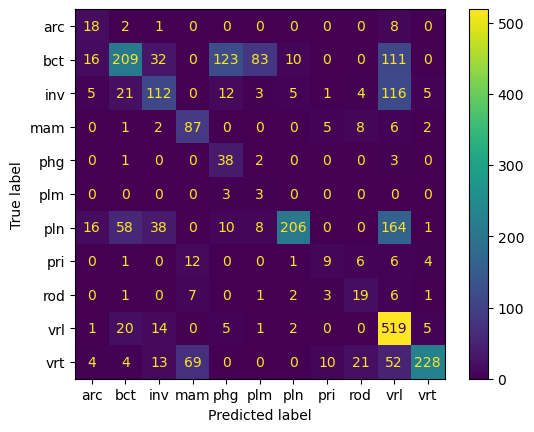

In [105]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()

## Logistic Regression


In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV

In [122]:
X_1 = codon_df_clean.drop(columns=['Kingdom_labels', 'SpeciesName', 'Kingdom', 'SpeciesID'])
y_1= codon_df_clean['Kingdom_labels']


X_train_lg, X_test_lg, y_train_lg, y_test_lg = train_test_split(X_1, y_1, test_size=0.2, random_state=34)

In [108]:
print(X_train_lg.shape)
print (y_train_lg.shape)

(10420, 66)
(10420,)


In [109]:
estimators_lg = [('normalise', StandardScaler()),
              #('reduce_dim', PCA()),
              ('lg', LogisticRegression(n_jobs=4, random_state=34, max_iter=10000))]

pipe_lg = Pipeline(estimators_lg)
print(pipe_lg)

Pipeline(steps=[('normalise', StandardScaler()),
                ('lg',
                 LogisticRegression(max_iter=10000, n_jobs=4,
                                    random_state=34))])


In [110]:
n_components = list(range(1, 10, 1))

# params for LogisticRegression()
# C values
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100] 

#define the parameter grid
params_lg = dict(
    #reduce_dim__n_components = n_components,
    lg__C = C,
)
print(f"parameter grid values: {params_lg}")

parameter grid values: {'lg__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}


In [111]:
grid_search_lg = GridSearchCV(pipe_lg, param_grid=params_lg, cv=5, scoring='accuracy')
grid_search_lg.fit(X_train_lg, y_train_lg)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('normalise', StandardScaler()),
                                       ('lg',
                                        LogisticRegression(max_iter=10000,
                                                           n_jobs=4,
                                                           random_state=34))]),
             param_grid={'lg__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='accuracy')

In [112]:
best_model = grid_search_lg.best_estimator_
#print(grid_search_lg.best_estimator_.get_params()['reduce_dim__n_components'])
print(grid_search_lg.best_estimator_.get_params()['lg__C'])
print(best_model)

1
Pipeline(steps=[('normalise', StandardScaler()),
                ('lg',
                 LogisticRegression(C=1, max_iter=10000, n_jobs=4,
                                    random_state=34))])


In [126]:
log_model_tunned = LogisticRegression(C=1, max_iter=10000, random_state=34)

In [127]:
log_model_tunned.fit(X_train_lg, y_train_lg)
print(f'Accuracy on train set: {log_model_tunned.score(X_train_lg, y_train_lg)}')
print(f'Accuracy on test set: {log_model_tunned.score(X_test_lg, y_test_lg)}')

Accuracy on train set: 0.22408829174664108
Accuracy on test set: 0.22409823484267075


In [128]:
y_train_pred = log_model_tunned.predict(X_train_lg)
y_test_pred = log_model_tunned.predict(X_test_lg)

In [129]:
from sklearn.metrics import classification_report
report_train = classification_report(y_train_lg, y_train_pred)
print(report_train)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        97
           1       0.22      1.00      0.37      2335
           2       0.00      0.00      0.00      1061
           3       0.00      0.00      0.00       461
           4       0.00      0.00      0.00       176
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00      2022
           7       0.00      0.00      0.00       141
           8       0.00      0.00      0.00       175
           9       0.00      0.00      0.00      2264
          10       0.00      0.00      0.00      1676

    accuracy                           0.22     10420
   macro avg       0.02      0.09      0.03     10420
weighted avg       0.05      0.22      0.08     10420



c:\Users\pier3\anaconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pier3\anaconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pier3\anaconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [130]:
report_test = classification_report(y_test_lg, y_test_pred)
print(report_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.22      1.00      0.37       584
           2       0.00      0.00      0.00       284
           3       0.00      0.00      0.00       111
           4       0.00      0.00      0.00        44
           5       0.00      0.00      0.00         6
           6       0.00      0.00      0.00       501
           7       0.00      0.00      0.00        39
           8       0.00      0.00      0.00        40
           9       0.00      0.00      0.00       567
          10       0.00      0.00      0.00       401

    accuracy                           0.22      2606
   macro avg       0.02      0.09      0.03      2606
weighted avg       0.05      0.22      0.08      2606



c:\Users\pier3\anaconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pier3\anaconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\pier3\anaconda3\envs\capstone\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


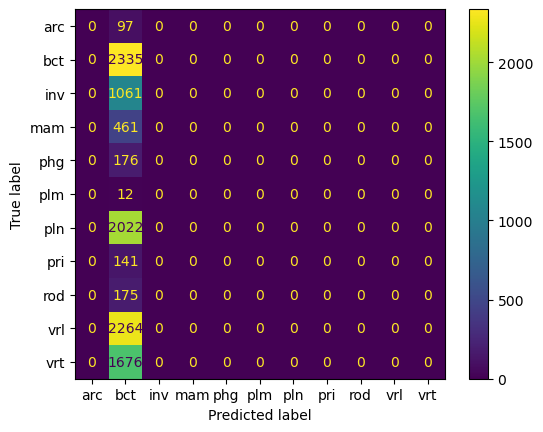

In [131]:
cm = confusion_matrix(y_train_lg, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()

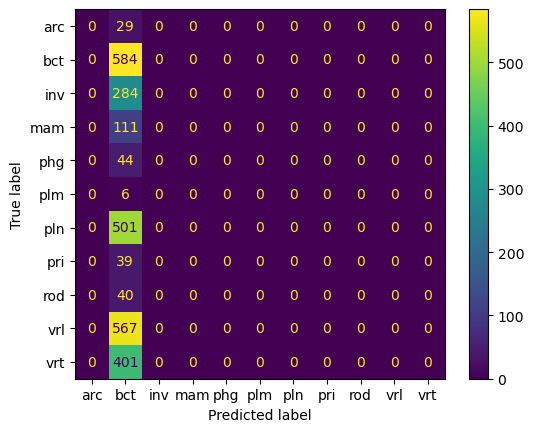

In [132]:
cm = confusion_matrix(y_test_lg, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()